# Vegetation Indices
We have a selection of vegetation indices available in FarmVibes.AI. This notebook demonstrates how to compute some of these indices on top of Sentinel-2 imagery using a user-defined workflow.

In [1]:
import io
from datetime import datetime

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import yaml
from IPython.display import Image, display
from rasterio.mask import mask
from shapely import geometry as shpg

from vibe_core.client import get_default_vibe_client

In [2]:
def lw_plot():
    """
    Compress images to make notebook smaller
    """
    iobytes = io.BytesIO()
    plt.savefig(iobytes, format='jpg', bbox_inches="tight")
    plt.close()
    iobytes.seek(0)
    display(Image(data=iobytes.read()))

def read_raster(raster, geometry=None, window=None, **kwargs):
    """
    Read data from a Raster. If a geometry or window is passed, only that portion of the raster is read.
    """
    with rasterio.open(raster.raster_asset.url, **kwargs) as src:
        if geometry is not None:
            return mask(src, [geometry], crop=True, **kwargs)[0]
        return src.read(window=window)
    
def s2_to_img(ar, rgb_idx=[3, 2, 1]):
    """
    Normalize Sentinel-2 RGB channels for display
    """
    return (ar[rgb_idx] / 3000).clip(0, 1).transpose((1, 2, 0))

In [3]:
client = get_default_vibe_client()

## Index computation workflow
One of the available data processing workflows is `data_processing/index/index`. It can be used as a task to compute an index given a raster. The index that will be computed by the workflow can be configured with the `index` parameter. We'll define a custom workflow that uses several tasks to compute many indices in parallel. The custom workflow, defined in `indices.yaml`, is shown below.

In [4]:
client.document_workflow("data_processing/index/index")

Workflow: data_processing/index/index

Description:

Computes an index from the bands of an input raster. Available indices are: NDVI, EVI, MSAVI,   
    NDRE, RECI, NDMI, and methane. The workflow requires the input raster to have the specific bands
    required to compute each index. The necessary bands are:                                        
     - NDVI and MSAVI: B04 and B08 (red and NIR)                                                    
     - EVI: B02, B04, B08 (blue, red, and NIR)                                                      
     - NDRE and RECI: B05, B08 (rededge1 and NIR)                                                   
     - NDMI: B08, B11 (NIR and SWIR16)                                                              
     - Methane: B01, B02, B03, B04, B05, B06, B07, B08, B8A, B09, and B12

Sources:

- raster (vibe_core.data.rasters.Raster): Input raster.

Sinks:

- index_raster (vibe_core.data.rasters.Raster): Single-band raster with the computed index.

Parameters:

- index (default: ndvi): The choice of index to be computed ('ndvi', 'evi', 'msavi', 'ndre',    
    'reci', 'ndmi' or 'methane').

Tasks:

- compute_index

In [5]:
# Sample custom workflow that uses a data ingestion workflow to download Sentinel-2 data
# and then computes several indices on the available imagery
!cat indices.yaml

name: indices
sources:
  user_input:
    - s2.user_input
sinks:
  s2: s2.raster
  ndvi: ndvi.index_raster
  evi: evi.index_raster
  ndmi: ndmi.index_raster
  ndre: ndre.index_raster
  reci: reci.index_raster
parameters:
  pc_key:
tasks:
  s2:
    workflow: data_ingestion/sentinel2/preprocess_s2
    parameters:
      pc_key: "@from(pc_key)"
  ndvi:
    workflow: data_processing/index/index
    parameters:
      index: ndvi
  evi:
    workflow: data_processing/index/index
    parameters:
      index: evi
  ndmi:
    workflow: data_processing/index/index
    parameters:
      index: ndmi
  ndre:
    workflow: data_processing/index/index
    parameters:
      index: ndre
  reci:
    workflow: data_processing/index/index
    parameters:
      index: reci
edges:
  - origin: s2.raster
    destination:
      - ndvi.raster
      - evi.raster
      - ndmi.raster
      - ndre.raster
      - reci.raster


## Submiting custom workflows
We can submit a custom workflow by loading its definition into a dictionary and using that instead of the name of a built-in workflow.

In [6]:
# Load our workflow definition in the YAML file into a dict
with open("indices.yaml") as f:
    wf_dict = yaml.safe_load(f)

# Define our workflow inputs.
geom = shpg.Point(-119.21896203939313, 46.44578909859286).buffer(.05, cap_style=3)
time_range = (datetime(2020, 5, 1), datetime(2020, 5, 5))

In [7]:
# Submit a run request by sending the worflow dictionary
run = client.run(wf_dict, "Vegetation indices", geometry=geom, time_range=time_range)
run.monitor()

Output()

## Workflow outputs
We defined several outputs in the workflow definition. The sink `s2` contains the original Sentinel-2 imagery, while the others contain the vegetation indices computed on top of it. Let's see what they look like

In [8]:
# Project the input geometry into our raster CRS
with rasterio.open(run.output["ndvi"][0].raster_asset.url) as src:
    proj_geom = gpd.GeoSeries(geom, crs="epsg:4326").to_crs(src.crs).iloc[0].envelope

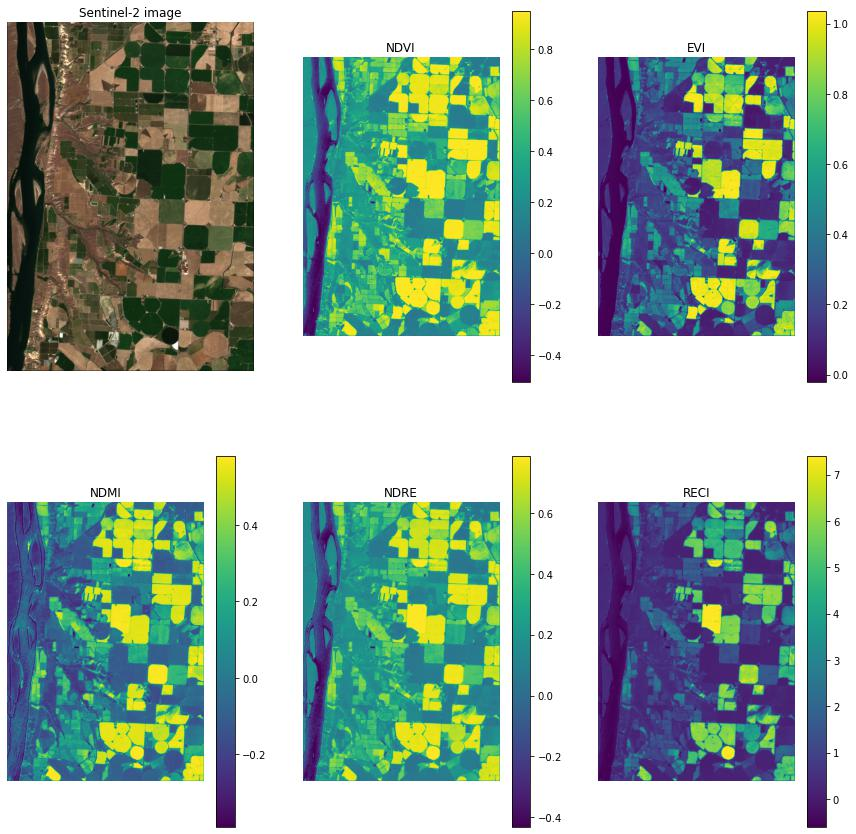

In [9]:
plt.figure(figsize=(15, 15))
# Read and plot the Sentinel-2 imagery
plt.subplot(2, 3, 1)
plt.imshow(s2_to_img(read_raster(run.output["s2"][0], geometry=proj_geom)))
plt.title("Sentinel-2 image")
plt.axis("off")

# Read and plot each of the indices=
for i, k in enumerate([k for k in run.output if k != "s2"], start=2):
    plt.subplot(2, 3, i)
    # Read index raster
    ar = read_raster(run.output[k][0], geometry=proj_geom, filled=False).filled(0)
    # Clip values to discard outliers
    qmin, qmax = np.quantile(ar, (.01, .99))
    ar = ar.clip(qmin, qmax)
    # Plot index values
    plt.imshow(ar[0])
    plt.axis("off")
    plt.colorbar()
    plt.title(k.upper())
lw_plot()